In [1]:
#import libs
import sys,os
import numpy as np

#move into directory above ricepaper lib
os.chdir('../..')

from ricepaper.material import NodeSet, MechLab
from ricepaper import RicePaper
from ricepaper.utils import *

import matplotlib.pyplot as plt

In [2]:
#define a material
mat = NodeSet("Test_Material",[30,25,20], #radii
                         2500, #densities (applied to all radii)
                         6.96e9, #young's modulus (applied to all radii)
                         0.2) #poisson ratio (applied to all radii)
mat.setFriction(0.4) #friction coefficient
mat.setBonding( 6.96e9, #normal stiffness (Pa)
                2.9e9, #shear stiffness (Pa)
                100e6, #tensile strength (Pa)
                50e6) #shear strength (Pa)

Once node types have been defined we can fill a domain with this "material" by gravity deposition. This can be used to build both conical piles or fill an entire domain:

In [3]:
os.getcwd()

'/home/user1/Documents/notebooks/riceball'

In [6]:
mat.R.restart

'STATE_2.SAV'

In [5]:
#generate a pile
R = mat.gravityDeposit(750,1500,base=3000, stepSize=200, walltype=3,suppress=True)

Generating 125 particles in layer 0
Generating 125 particles in layer 1
Generating 125 particles in layer 2
Generating 125 particles in layer 3
Average kinetic energy = 1.242398E+09
Average kinetic energy = 2.365124E+08
Average kinetic energy = 4.288505E+07
Average kinetic energy = 2.048033E+07
Average kinetic energy = 2.171509E+02
Average kinetic energy = 1.266658E-03
Model equilibrated in 0.018968 minutes


/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


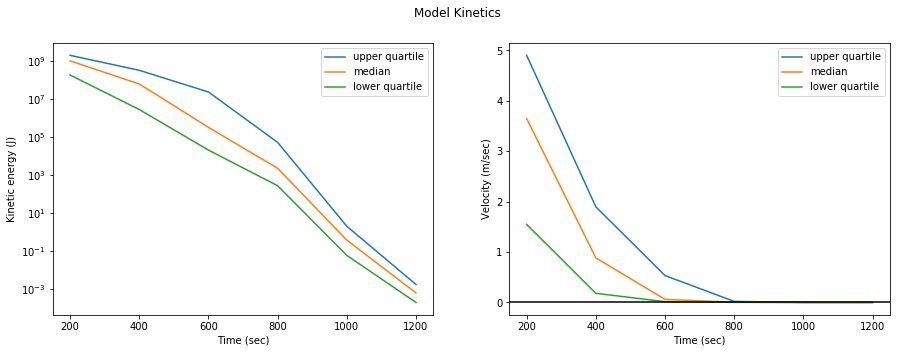

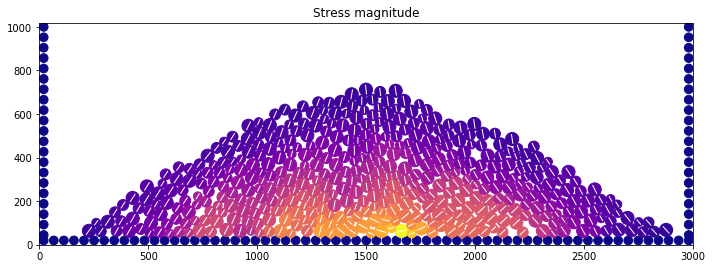

In [6]:
#get steps
steps = list(range(1,R.file+1))

#plot equilibration curves
fig,ax = R.plotKinetics(steps)

#plot final model
m = R.loadLastOutput()
m.averageAttr("stress",n = 5)
fig,ax = m.plotAttr("stress",ignoreFixed=False,title="Stress magnitude")

In [7]:
#generate a gravity settled domain
R = mat.gravityDeposit(1000,1000,walltype=3,suppress=False)

Generating 111 particles in layer 0
Generating 111 particles in layer 1
Generating 111 particles in layer 2
Generating 111 particles in layer 3
'Test_Material/gravity_settle' finished in 0.02 minutes.
Average kinetic energy = 1.603517E+09
'Test_Material/gravity_settle' finished in 0.05 minutes.
Average kinetic energy = 4.506232E+07
'Test_Material/gravity_settle' finished in 0.07 minutes.
Average kinetic energy = 1.447262E-03
Model equilibrated in 0.151150 minutes


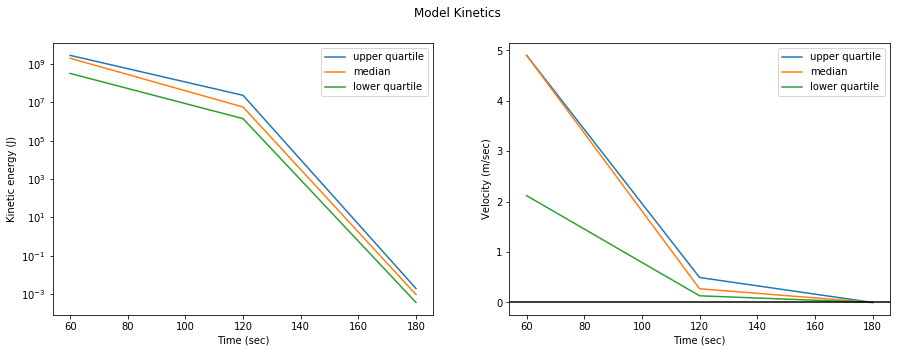

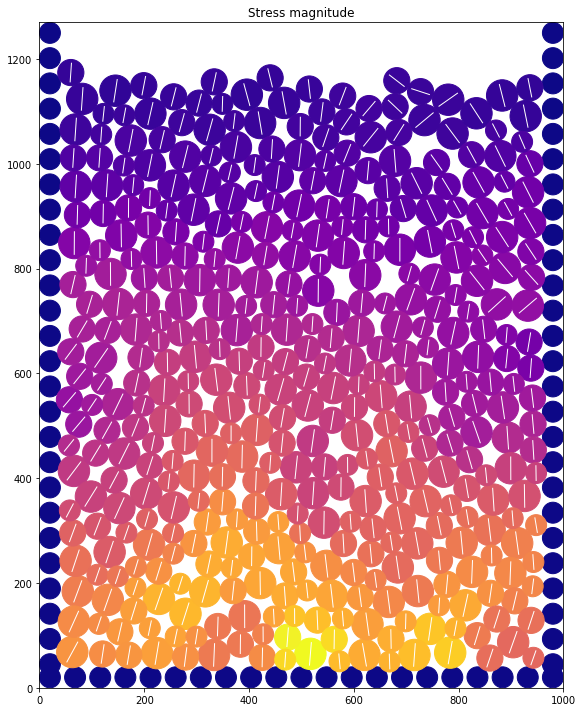

In [8]:
#get steps
steps = list(range(1,R.file+1))

#plot equilibration curves
fig,ax = R.plotKinetics(steps)

#plot model
m = R.loadLastOutput()
m.averageAttr("stress",n = 5)
fig,ax = m.plotAttr("stress",ignoreFixed=False,figSize=(5,7),title="Stress magnitude")

Material Characterisation
========

As bulk properties cannot be expicitely defined in DEM models, it is necessary to perform "numerical tests" to characterise and calibrate each material. Ricepaper.material contains a MechLab class for performing such tests.

Launching job 1 of 6.
Launching job 2 of 6.
Launching job 3 of 6.
Launching job 4 of 6.
Launching job 5 of 6.
Launching job 6 of 6.
'Test_Material/shear_test/10000000_Pa' finished in 0.24 minutes.
'Test_Material/shear_test/5000000_Pa' finished in 0.23 minutes.
'Test_Material/shear_test/7500000_Pa' finished in 0.23 minutes.
'Test_Material/shear_test/20000000_Pa' finished in 0.24 minutes.
'Test_Material/shear_test/12500000_Pa' finished in 0.24 minutes.
'Test_Material/shear_test/15000000_Pa' finished in 0.24 minutes.


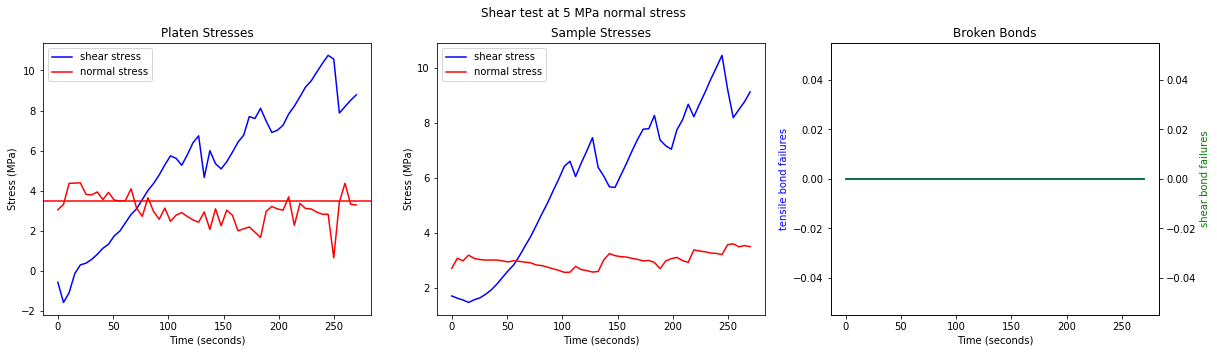

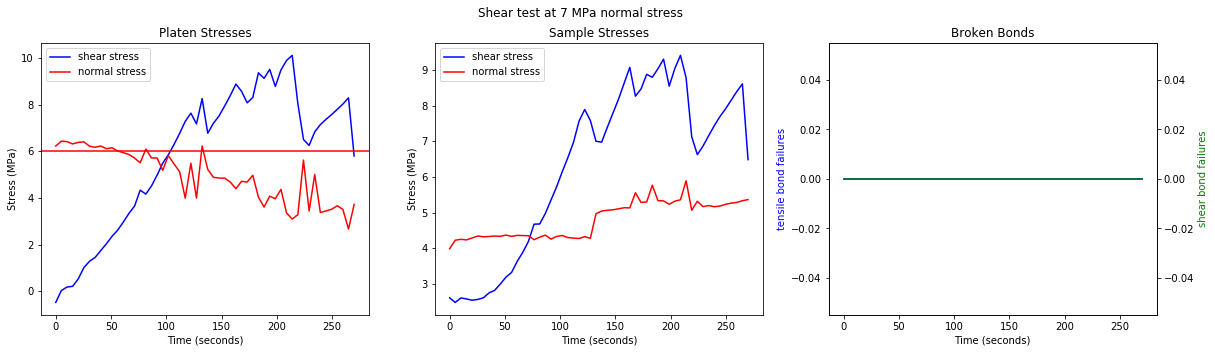

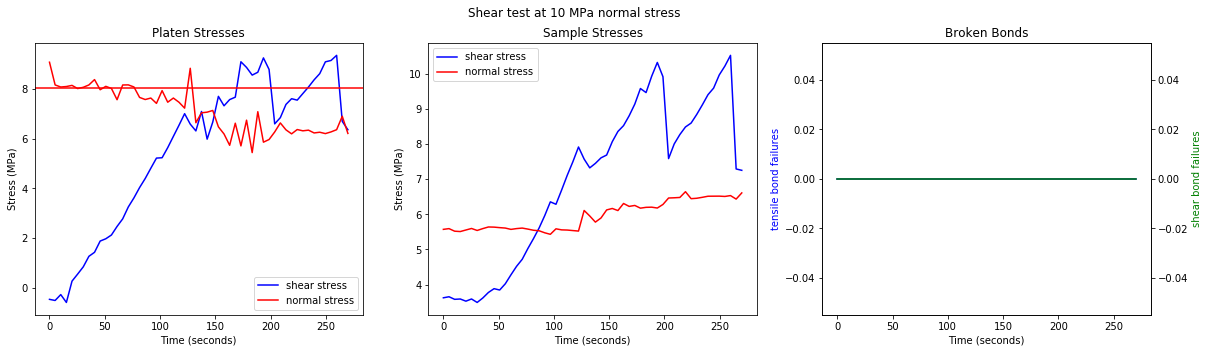

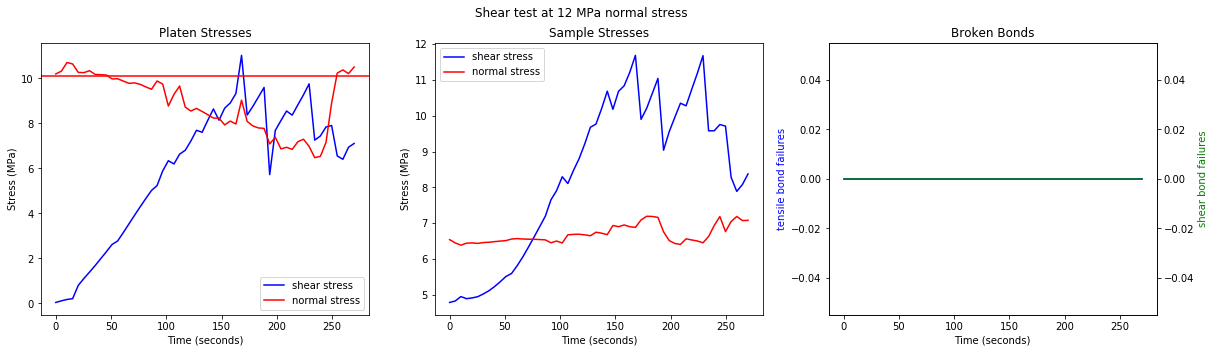

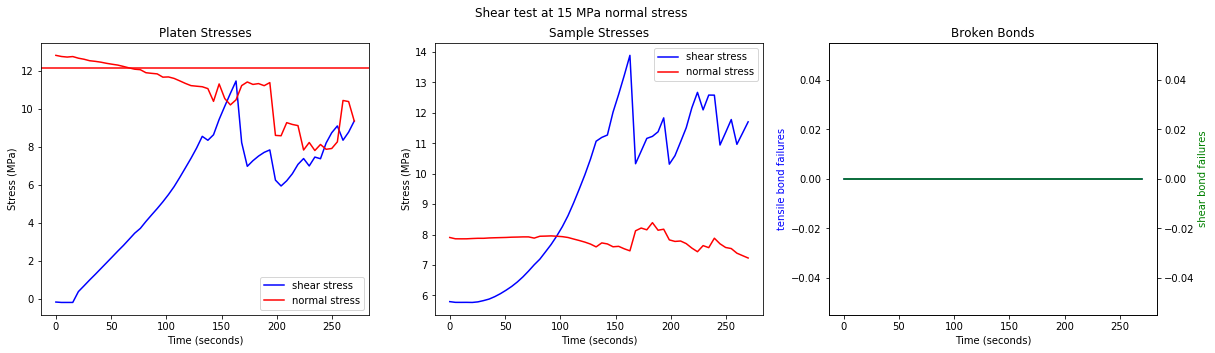

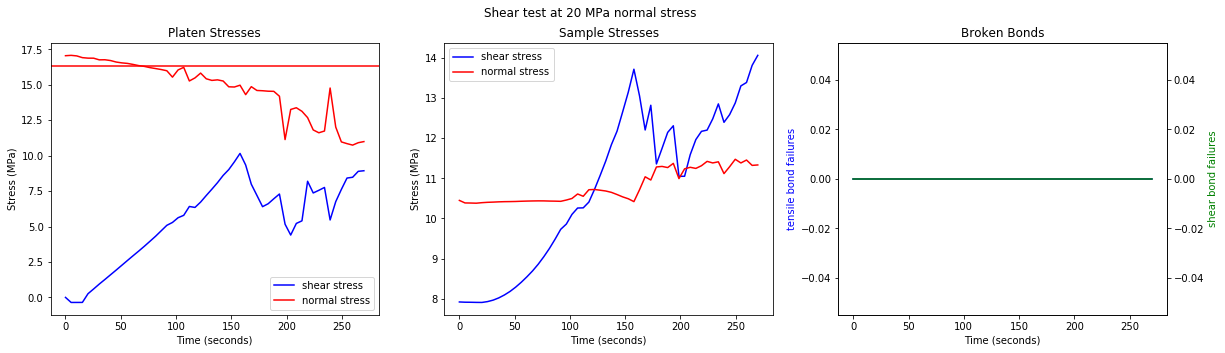

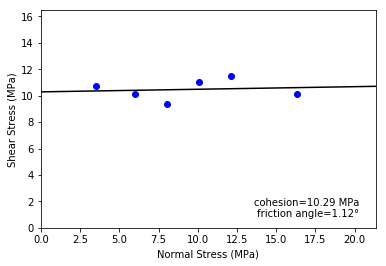

In [9]:
#setup mechanics lab
M = MechLab( mat, initTime = 20, testTime = 250, stepSize = 5 )

#setup shear tests
NS = [5e6,7.5e6,10e6,12.5e6,15e6,20e6]
for ns in NS:
    T = M.addShearTest(ns,0.5,yvel=10,bond=True)
    
#run tests
M.runTests(multiThreaded=True, suppress=False)

#plot results
M.plotShearResults()

#save
#M.writeToVTK()

Similarly, MechLab can be used to run compression tests to characterise compressive strength, young's modulus and poissons ratio.

In [13]:
"""
Create a compression test and add it to the execution queue.

**Arguments**:
 - confining_stress = the confining stress to apply during the material during the test. 
 - rate = the velocity of the platen during the compression experiment. 

**Keywords**:
 -bond = True if bonds should be generated before executing the test. Default is True. 
"""

def addCompressionTest(self,confining_stress,rate,**kwds):
    #clone ricepaper interface
    name = "%s/compression_test/%d_Pa" % (self.mat.name,confining_stress)
    R = self.mat.R.clone(name)

    #create new test
    T = MechLab.Test( name, "compression", self, R)

    #store test params
    T.confining = confining_stress
    T.xvel = rate
    
    ##############################
    #turn of gravity and bond
    ##############################
    R.setGravity((0,0,0))
    R.setNumericalProperties(timestep=self.tstep)
    if kwds.get("bond",True):
        R.makeBonds(np.max(self.mat.radii)*1.25,moments=kwds.get("moments",False))
        
    #############################################
    #create upper/lower (confining) platens
    #############################################
    R.custom("\n********************")
    R.custom("**Setup confining platens**")
    R.custom("********************")
    R.custom("Wall Pos %.3f %.3f" % (self.upper,self.lower)) #set position of platens
    R.custom("Wall Nstress %.3f" % (confining_stress)) #set normal stress
    R.custom("Wall Gain %E" % (1e-5)) #set large number for servo gain (we use velocity as the limit)
    R.custom("Wall Vel 20") #set maximum normal velocity 
    R.custom("Wall Xvel 0 0") #zero shear velocity

        
    #################################################################
    #setup init phase (apply confining stress and let stabilise)
    #################################################################
    T.initSteps = int(self.initTime / self.stepSize)
    for i in range(T.initSteps):
        T.steps.append( R.cycle(self.stepSize) )
    
    #convert upper platen to force-controlled wall
    R.custom("FWL %E" % (confining_stress))
    
    #############################################
    #create side (compressive) platens
    #############################################
    R.custom("\n********************")
    R.custom("**Setup compression platens**")
    R.custom("********************")
    R.setDomain( 0, self.init_xmin, self.lower+np.max(self.mat.radii), self.mat.height-np.max(self.mat.radii), 0,  self.mat.depth )
    R.custom("PRP 1 COL x 3")
    R.custom("PRP 1 VEL %.6f 0 0" % rate)
    R.custom("PRP 1 FIX 1 1 1 1 1 1")
    
    ########################
    #setup compression phase
    ########################
    T.testSteps = int(self.testTime/self.stepSize)
    for i in range(T.testSteps):
        T.steps.append( R.cycle(self.stepSize) )

    #store test and return 
    self.tests.append( T )

    return T

In [14]:
"""
Plot the results of compression experiments.

**Arguments**:
 - detailed = If true, detailed stress plots for each sample are plotted, as well as the overall mohr-coloumb failure envelope.
              If false, only the failure envelope is plotted. 
"""
def plotCompressionResults( self, detailed = True, **kwds ):
    maxS = [] #maximum stress
    NS = [] #applied confining stress (75th percentile, though should be quite constant)...
    for T in self.tests:
        if T.type != "compression":
            continue

        #make sure results have been loaded
        T.load_results()

        #extract maxima
        maxS.append(np.max(T.compressive_stress))
        NS.append(np.percentile(T.normal_stress,75))

        #setup fig
        fig,ax = plt.subplots(1,3,figsize=(20,5))

        #plot stress-strain curve
        strain = (T.initial_width-T.sample_width) / T.initial_width
        ax[0].plot(T.time,T.compressive_stress/1e6,color="blue",label="compressive stress")
        ax[0].plot(T.time,T.normal_stress/1e6,color="red",label="confining stress")
        ax[0].axhline(NS[-1]/1e6,color='red')
        ax[0].set_title("Platen Stresses")
        ax[0].set_xlabel("Time (seconds)")
        ax[0].set_ylabel("Stress (MPa)")
        ax[0].legend()

        #get stress in sample
        sig1 = []
        sig3 = []
        for s in T.sample_stress:
            #calculate principal stresses
            eigval, eigvec = np.linalg.eig(s)
            idx = eigval.argsort()[::-1]
            eigval = eigval[idx]
            eigvec = eigvec[:,idx]

            sig1.append(eigval[0])
            sig3.append(eigval[1])

        ax[1].plot(T.time,np.array(sig1)/1e6,color='blue',label="compressive stress (sig1)")
        ax[1].plot(T.time,np.array(sig3)/1e6,color='red', label="confining stress (sig3)")
        ax[1].set_title("Sample Stresses")
        ax[1].set_xlabel("Time (seconds)")
        ax[1].set_ylabel("Stress (MPa)")
        ax[1].legend()

        #plot broken bonds
        x = list(range(0,len(T.models)))
        tensile = []
        shear = []
        for m in T.models:
            tcount = 0
            scount = 0
            for b in m.brk:
                if b[0] == 'Tensile Failure':
                    tcount+=1
                elif b[0] == 'Shear Failure':
                    scount+=1
                elif b[0] == 'Tens-shear Failure':
                    scount+=1
                    tcount+=1
                else:
                    print(b)
                    assert False
            tensile.append(tcount)
            shear.append(scount)
        ax[2].plot(T.time,tensile,color='b',label="tensile")
        ax[2].set_ylabel("tensile bond failures",color="b")
        ax2 = ax[2].twinx()
        ax2.plot(T.time,shear,color='g',label="shear")
        ax2.set_ylabel("shear bond failures",color="g")
        ax[2].set_title("Broken Bonds")
        ax[2].set_xlabel("Time (seconds)")
        fig.suptitle("Shear test at %d MPa normal stress" % (T.confining/1e6))
        fig.show()

    #plot Coloumb failure line
    if len(NS) > 1 and False: #can't do for only one test..
        plt.figure()
        x = np.array(NS) / 1e6
        y = np.array(maxS) / 1e6
        plt.scatter(x,y,color='b')
        k,m = np.polyfit(x,y,1)
        plt.plot([0,np.max(x)+5],[m,(np.max(x)+5)*k+m],color='k')
        plt.text(0.95,0.1,"cohesion=%.2f MPa" % m,transform=plt.gca().transAxes,horizontalalignment='right')
        plt.text(0.95,0.05,"friction angle=%.2f°" % np.rad2deg(np.arctan(k)),transform=plt.gca().transAxes,horizontalalignment='right')

        plt.xlim(0,np.max(x)+5)
        plt.ylim(0,np.max(y)+5)
        plt.ylabel("Compressive Stress (MPa)")
        plt.xlabel("Confining Stress (MPa)")
        plt.show()

In [15]:
#setup mechanics lab
M = MechLab( mat, initTime = 20, testTime = 250, stepSize = 5 )

#setup compression tests
confining = [5e6,10e6,20e6]
for c in confining:
    #T = M.addShearTest(ns,0.5,yvel=0.5,bond=True)
    T = addCompressionTest(M,c,0.5)
#run tests
M.runTests(multiThreaded=True, suppress=False)

Launching job 1 of 3.
Launching job 2 of 3.
Launching job 3 of 3.
'Test_Material/compression_test/10000000_Pa' finished in 0.31 minutes.
'Test_Material/compression_test/20000000_Pa' finished in 0.31 minutes.
'Test_Material/compression_test/5000000_Pa' finished in 0.31 minutes.


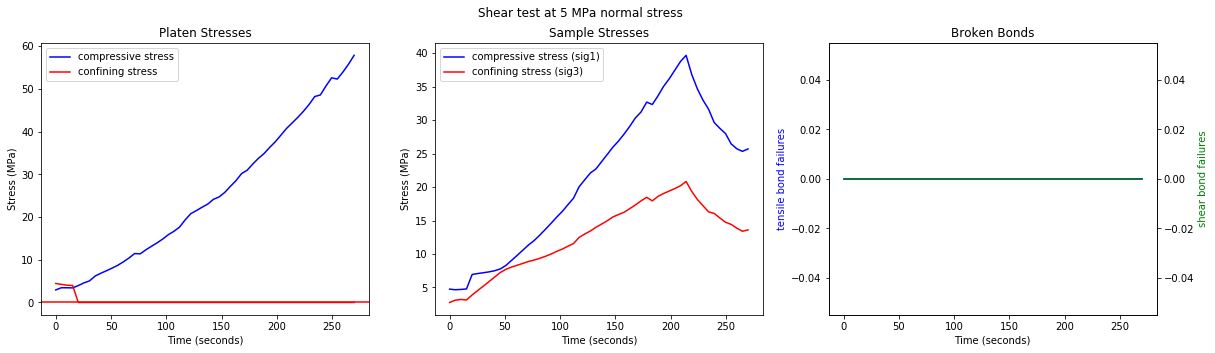

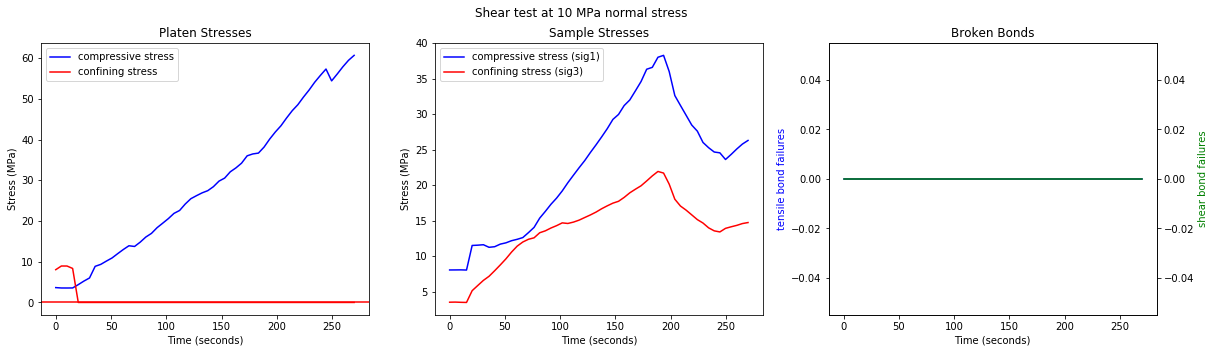

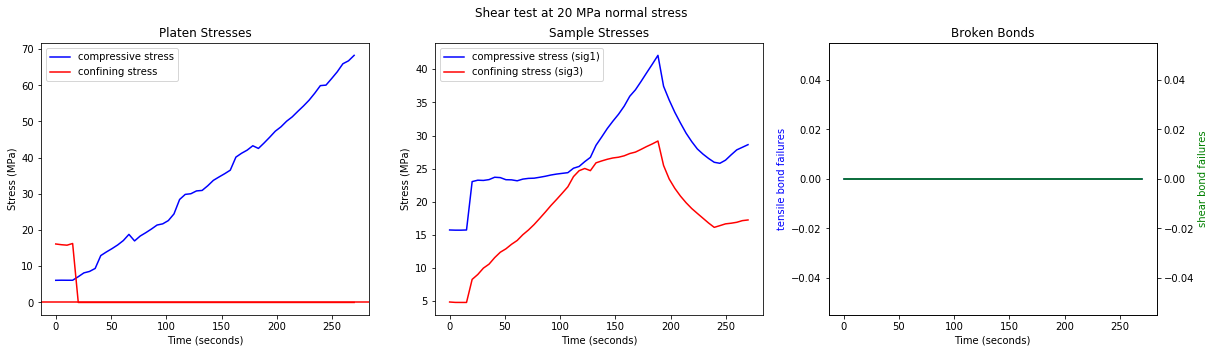

In [16]:
#plot results
plotCompressionResults(M,True)

/home/user1/Documents/notebooks/riceball/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


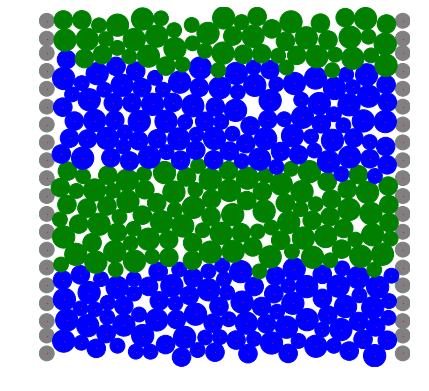

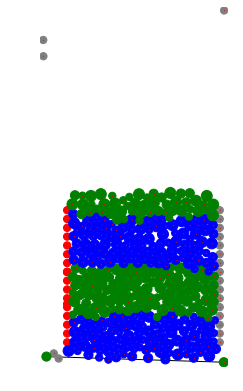

In [17]:
M.tests[2].models[0].quickPlot()
M.tests[2].models[-1].quickPlot()